In [1]:
from pathlib import Path
import sys

project_root = Path.cwd()
sys.path.insert(0, str(project_root / "src"))

from tab_hero.dataio.tab_format import load_tab
from tab_hero.dataio.tokenizer import ChartTokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


In [2]:
data_dir = Path("../data/processed")
tab_path = next(data_dir.glob("*.tab"))

data = load_tab(tab_path)


print("Loaded:", tab_path.name)
print("Attributes:", data.__dict__.keys())


Loaded: 0005baeaa7465a4c.tab
Attributes: dict_keys(['mel_spectrogram', 'sample_rate', 'hop_length', 'note_tokens', 'difficulty_id', 'instrument_id', 'content_hash', 'song_id'])


In [3]:
mel = np.array(data.mel_spectrogram)
tokens = np.array(data.note_tokens, dtype=np.int32)

print("mel shape:", mel.shape)
print("tokens shape:", tokens.shape)

mel shape: (128, 36812)
tokens shape: (4498,)


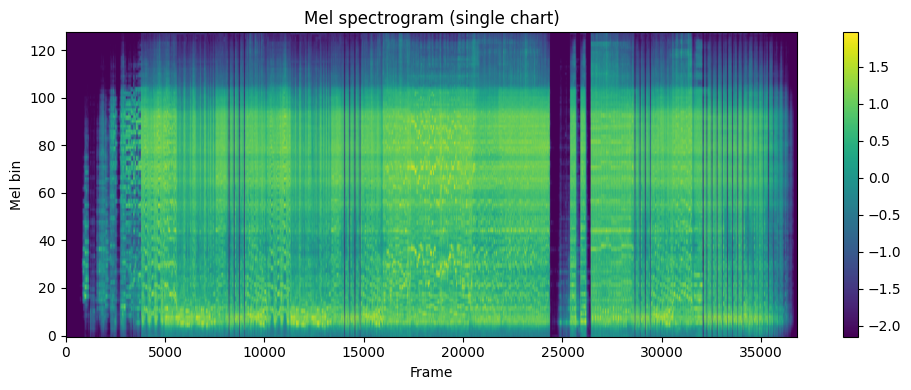

In [4]:
plt.figure(figsize=(10, 4))
plt.imshow(mel, aspect="auto", origin="lower")
plt.xlabel("Frame")
plt.ylabel("Mel bin")
plt.title("Mel spectrogram (single chart)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [5]:
tokenizer = ChartTokenizer()

toks = tokens

time_mask = (toks >= tokenizer._time_token_start) & (toks < tokenizer._time_token_end)
fret_mask = (toks >= tokenizer._fret_token_start) & (toks < tokenizer._fret_token_end)
mod_mask  = (toks >= tokenizer._mod_token_start)  & (toks < tokenizer._mod_token_end)
dur_mask  = (toks >= tokenizer._dur_token_start)  & (toks < tokenizer._dur_token_end)

counts = {
    "TIME": int(time_mask.sum()),
    "FRET": int(fret_mask.sum()),
    "MOD":  int(mod_mask.sum()),
    "DUR":  int(dur_mask.sum()),
}
counts


{'TIME': 1124, 'FRET': 1124, 'MOD': 1124, 'DUR': 1124}

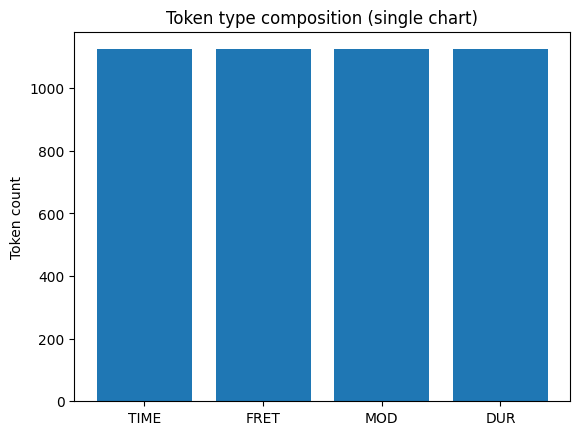

In [6]:
plt.bar(counts.keys(), counts.values())
plt.ylabel("Token count")
plt.title("Token type composition (single chart)")
plt.show()

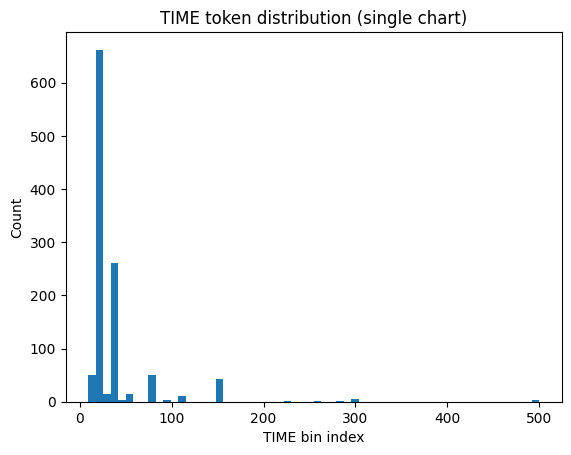

TIME stats: mean 34.71797153024911 std 43.206485082458215 median 18.0


In [7]:
time_bins = toks[time_mask] - tokenizer._time_token_start

plt.hist(time_bins, bins=60)
plt.xlabel("TIME bin index")
plt.ylabel("Count")
plt.title("TIME token distribution (single chart)")
plt.show()

print(
    "TIME stats:",
    "mean", float(time_bins.mean()),
    "std", float(time_bins.std()),
    "median", float(np.median(time_bins))
)


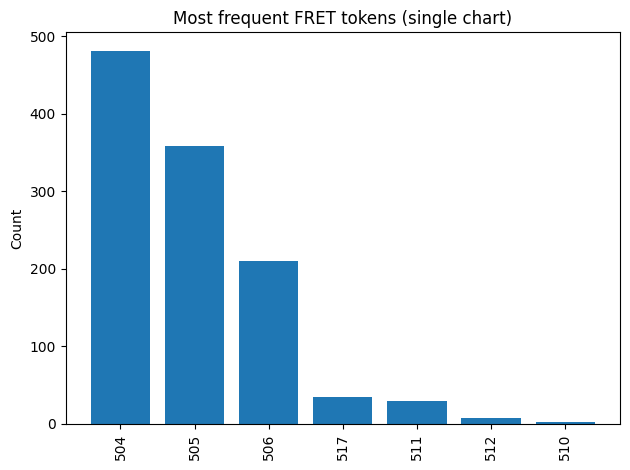

In [8]:
fret_tokens = toks[fret_mask]

unique, freq = np.unique(fret_tokens, return_counts=True)
order = np.argsort(freq)[::-1][:15]

plt.bar([str(u) for u in unique[order]], freq[order])
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Most frequent FRET tokens (single chart)")
plt.tight_layout()
plt.show()


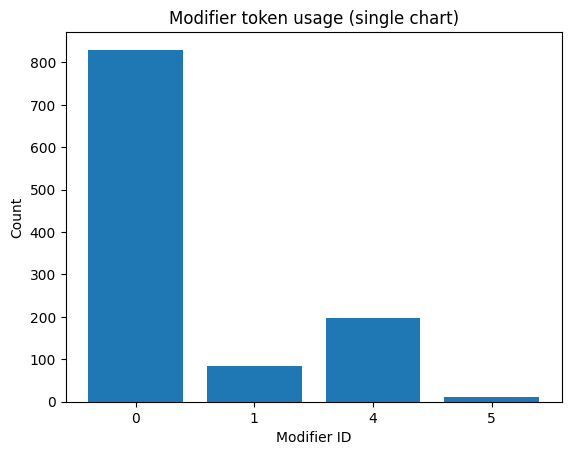

In [9]:
mod_tokens = toks[mod_mask] - tokenizer._mod_token_start

unique, freq = np.unique(mod_tokens, return_counts=True)

plt.bar(unique.astype(str), freq)
plt.xlabel("Modifier ID")
plt.ylabel("Count")
plt.title("Modifier token usage (single chart)")
plt.show()


In [10]:
tab_files = list(data_dir.glob("*.tab"))
sample_files = random.sample(tab_files, k=min(200, len(tab_files)))


In [11]:
rows = []

for p in sample_files:
    d = load_tab(p)
    mel = np.array(d.mel_spectrogram)
    toks = np.array(d.note_tokens, dtype=np.int32)

    time_mask = (toks >= tokenizer._time_token_start) & (toks < tokenizer._time_token_end)
    fret_mask = (toks >= tokenizer._fret_token_start) & (toks < tokenizer._fret_token_end)
    mod_mask  = (toks >= tokenizer._mod_token_start)  & (toks < tokenizer._mod_token_end)
    dur_mask  = (toks >= tokenizer._dur_token_start)  & (toks < tokenizer._dur_token_end)

    rows.append({
        "content_hash": p.stem,
        "n_frames": mel.shape[1],
        "mel_mean": float(mel.mean()),
        "mel_std": float(mel.std()),
        "n_tokens": int(len(toks)),
        "time_frac": float(time_mask.mean()),
        "fret_frac": float(fret_mask.mean()),
        "mod_frac": float(mod_mask.mean()),
        "dur_frac": float(dur_mask.mean()),
    })

df_raw = pd.DataFrame(rows)
df_raw.head()

,content_hash,n_frames,mel_mean,mel_std,n_tokens,time_frac,fret_frac,mod_frac,dur_frac
0,575bcd23da1cb171,12875,0.000026,0.999942,758,0.249340,0.249340,0.249340,0.249340
1,d8022494299571ca,29630,0.000038,0.999886,2194,0.249772,0.249772,0.249772,0.249772
2,e0aa889e5fdc24af,22481,-0.000002,1.000003,1062,0.249529,0.249529,0.249529,0.249529
3,3f75349e07ef1065,15167,-0.000016,1.000041,734,0.249319,0.249319,0.249319,0.249319
4,37f64583987eb771,27601,0.000004,0.999988,1602,0.249688,0.249688,0.249688,0.249688


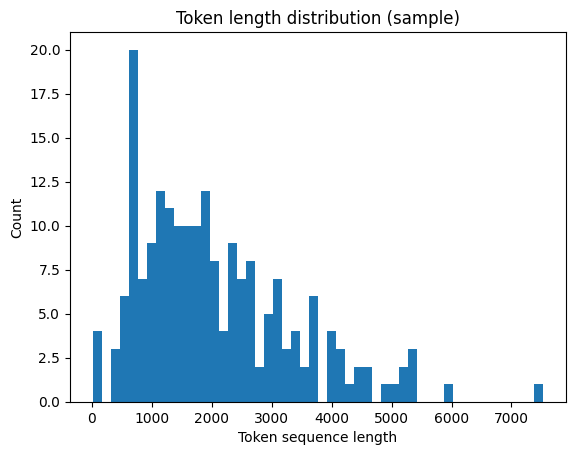

In [12]:
plt.hist(df_raw["n_tokens"], bins=50)
plt.xlabel("Token sequence length")
plt.ylabel("Count")
plt.title("Token length distribution (sample)")
plt.show()


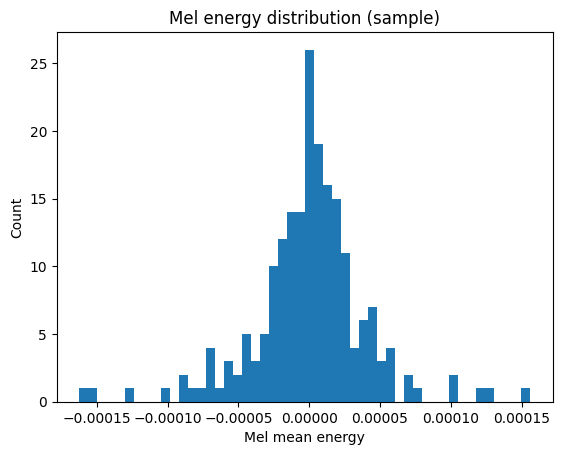

In [13]:
plt.hist(df_raw["mel_mean"], bins=50)
plt.xlabel("Mel mean energy")
plt.ylabel("Count")
plt.title("Mel energy distribution (sample)")
plt.show()


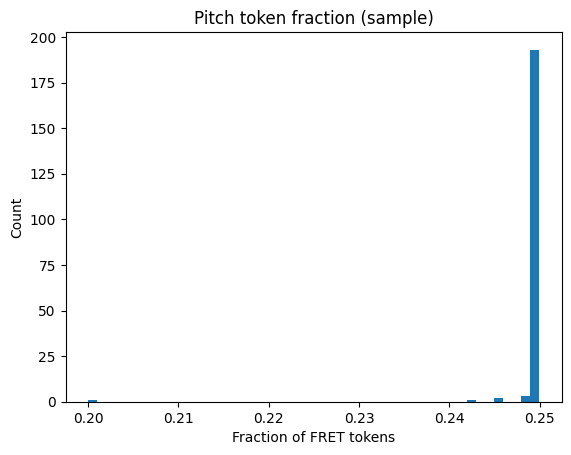

In [14]:
plt.hist(df_raw["fret_frac"], bins=50)
plt.xlabel("Fraction of FRET tokens")
plt.ylabel("Count")
plt.title("Pitch token fraction (sample)")
plt.show()


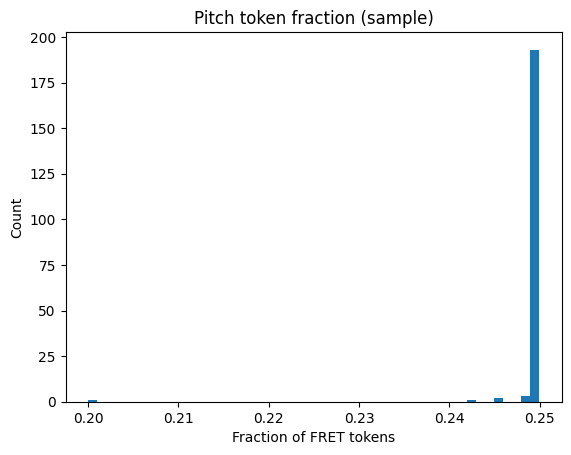

In [15]:
plt.hist(df_raw["fret_frac"], bins=50)
plt.xlabel("Fraction of FRET tokens")
plt.ylabel("Count")
plt.title("Pitch token fraction (sample)")
plt.show()
